# Time

## Save/Load Plot

In [1]:
import pandas as pd

bytes_amnt = {
    'torch.float32': 4,
}

df = pd.read_csv('mtd_model_time_results.csv')

df['model_n_bytes_per_weights'] = df['model_dtype_str'].map(bytes_amnt)
df.drop(columns=['model_dtype_str'], inplace=True)

df['model_size_bytes'] = df['model_n_bytes_per_weights'] * df['model_n_weights']
df['model_size_mb'] = df['model_size_bytes'] / 1024 / 1024

df.drop(columns=['model_n_bytes_per_weights', 'model_n_weights', 'model_size_bytes'], inplace=True)

# df_m = pd.melt(df, id_vars=['run_name', 'model_name', 'model_size_mb'], value_vars=['time_construct_mtd', 'time_obfuscate_mtd', 'time_deobfuscate_mtd', 'time_save_mtd', 'time_load_mtd', 'time_encrypt_crypto', 'time_decrypt_crypto', 'time_load_reg', 'time_save_reg'], var_name='action', value_name='time_seconds')

df_m = pd.melt(df, id_vars=['run_name', 'model_name', 'model_size_mb'], value_vars=['time_construct_mtd','time_save_mtd', 'time_load_mtd', 'time_load_reg', 'time_save_reg'], var_name='action', value_name='time_seconds')

df_m['action'] = df_m['action'].str.replace('time_', '')

df_m['method'] = df_m['action'].str.split('_').str[1]

df_m['action'] = df_m['action'].str.replace('_mtd', '')
df_m['action'] = df_m['action'].str.replace('_crypto', '')
df_m['action'] = df_m['action'].str.replace('_reg', '')

df_m=df_m[df_m['action'] != 'construct'].copy()
df_m.loc[(df_m['action'] == 'encrypt'), 'action'] = 'obfuscate'
df_m.loc[(df_m['action'] == 'decrypt'), 'action'] = 'deobfuscate'

# df_m.drop(columns=['model_size_mb'], inplace=True)
df_m

,run_name,model_name,model_size_mb,action,time_seconds,method
1210,0,alexnet,233.081207,save,0.531650,mtd
1211,1,alexnet,233.081207,save,0.539926,mtd
1212,2,alexnet,233.081207,save,0.535773,mtd
1213,3,alexnet,233.081207,save,1.066866,mtd
1214,4,alexnet,233.081207,save,1.072442,mtd
...,...,...,...,...,...,...
6045,5,wide_resnet50_2,262.768707,save,0.260670,reg
6046,6,wide_resnet50_2,262.768707,save,0.260516,reg
6047,7,wide_resnet50_2,262.768707,save,0.260536,reg
6048,8,wide_resnet50_2,262.768707,save,0.260692,reg


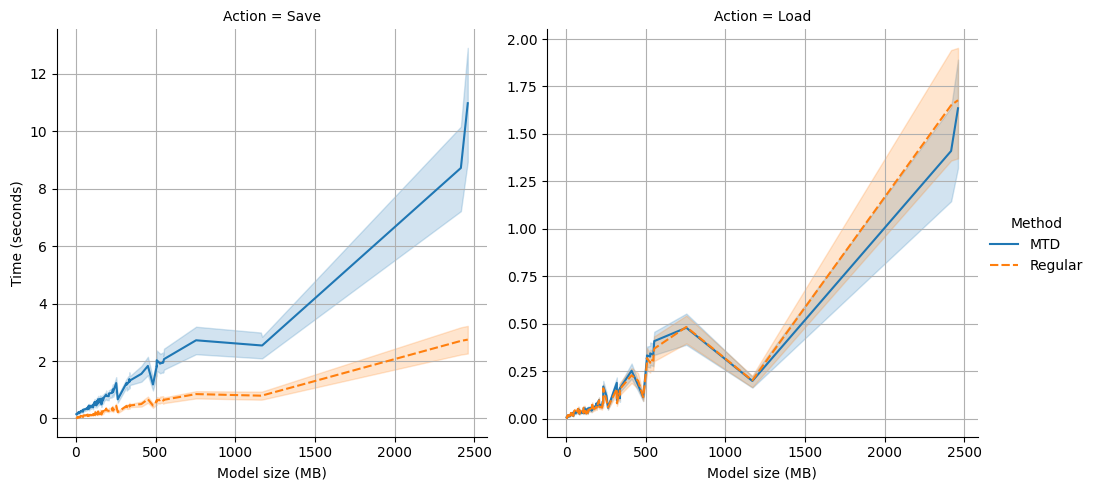

In [2]:
import seaborn as sns

val_map = {
    'action': {
        'construct': 'MTD Model Object Construction',
        'obfuscate': 'Obfuscation/Encryption',
        'deobfuscate': 'Deobfuscation/Decryption',
        'save': 'Save',
        'load': 'Load',
        'encrypt': 'Encryption',
        'decrypt': 'Decryption',
    },
    'method': {
        'mtd': 'MTD',
        'crypto': 'Crypto',
        'reg': 'Regular',
    }
}

df_m.replace(val_map, inplace=True)

col_map = {
    'model_size_mb': 'Model size (MB)',
    'time_seconds': 'Time (seconds)',
    'action': 'Action',
    'method': 'Method',
}
df_m.rename(columns=col_map, inplace=True)

g = sns.relplot(data=df_m,
            x=col_map['model_size_mb'], y=col_map['time_seconds'],
            hue=col_map['method'], col=col_map['action'],
            style=col_map['method'],
            col_wrap=2, kind='line',
            facet_kws={'sharey': False}
            )

# sns.move_legend(g, 'center', frameon=True, bbox_to_anchor=(0.46, 0.5))
# g._legend.remove()

for ax in g.axes.flat:
    ax.grid(True)

## Table

In [3]:
import pandas as pd

df = pd.read_csv(f'mtd_model_time_results.csv')

bytes_amnt = {
    'torch.float32': 4,
}

df['model_n_bytes_per_weights'] = df['model_dtype_str'].map(bytes_amnt)
df.drop(columns=['model_dtype_str'], inplace=True)

df['model_size_bytes'] = df['model_n_bytes_per_weights'] * df['model_n_weights']
df['model_size_mb'] = df['model_size_bytes'] / 1024 / 1024

df.drop(columns=['model_n_bytes_per_weights', 'model_n_weights', 'model_size_bytes'], inplace=True)
df.drop(columns=[
    'time_construct_mtd', 'time_save_mtd', 'time_load_mtd',
])

df['Q'] = df['model_size_mb'] // 100.0
df['group'] = df['Q'].apply(lambda x: f'{x*100:.0f} <= Model Size (MB) < {(x+1)*100:.0f}')

df = df.groupby(['group', 'Q']).agg({
    'time_obfuscate_mtd': ['mean', 'std'],
    'time_deobfuscate_mtd': ['mean', 'std'],
    'time_encrypt_crypto': ['mean', 'std'],
    'time_decrypt_crypto': ['mean', 'std'],
}).reset_index()
df
df.columns = ['group', 'Q'] + [f'{col[0]}_{col[1]}' for col in df.columns[2:]]

def format_std(mean, std):
    return f"{mean:.6f} ± {std:.6f}"

df['obfuscate'] = df.apply(lambda row: format_std(row['time_obfuscate_mtd_mean'], row['time_obfuscate_mtd_std']), axis=1)
df['deobfuscate'] = df.apply(lambda row: format_std(row['time_deobfuscate_mtd_mean'], row['time_deobfuscate_mtd_std']), axis=1)
df['encrypt'] = df.apply(lambda row: format_std(row['time_encrypt_crypto_mean'], row['time_encrypt_crypto_std']), axis=1)
df['decrypt'] = df.apply(lambda row: format_std(row['time_decrypt_crypto_mean'], row['time_decrypt_crypto_std']), axis=1)

df = df[['group', 'obfuscate', 'deobfuscate', 'encrypt', 'decrypt', 'Q']]
df.sort_values(by='Q', inplace=True)
df.drop(columns=['Q'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,group,obfuscate,deobfuscate,encrypt,decrypt
0,0 <= Model Size (MB) < 100,0.003820 ± 0.002000,0.005795 ± 0.003956,0.244292 ± 0.115333,0.245123 ± 0.123005
1,100 <= Model Size (MB) < 200,0.008666 ± 0.002466,0.013184 ± 0.005763,0.680410 ± 0.126848,0.724327 ± 0.133060
2,200 <= Model Size (MB) < 300,0.014490 ± 0.004417,0.021955 ± 0.009834,1.225329 ± 0.231984,1.197840 ± 0.278559
3,300 <= Model Size (MB) < 400,0.017144 ± 0.002250,0.025935 ± 0.002614,1.648033 ± 0.388462,1.746837 ± 0.373579
4,400 <= Model Size (MB) < 500,0.024434 ± 0.006219,0.040424 ± 0.018690,2.898500 ± 0.236313,2.574974 ± 0.215552
5,500 <= Model Size (MB) < 600,0.019980 ± 0.001987,0.021760 ± 0.004777,3.002284 ± 0.217727,2.574076 ± 0.170747
6,700 <= Model Size (MB) < 800,0.037661 ± 0.005977,0.051598 ± 0.006328,5.552645 ± 0.103848,5.999168 ± 0.116049
7,1100 <= Model Size (MB) < 1200,0.051498 ± 0.000437,0.069661 ± 0.002010,7.697417 ± 0.152804,8.562226 ± 0.158626
8,2400 <= Model Size (MB) < 2500,0.109626 ± 0.023599,0.134600 ± 0.019062,17.901734 ± 0.261984,19.233927 ± 0.467096


In [4]:
# print latex table
latex_table = df.to_latex(index=False, escape=False, column_format='lcccc')
print(latex_table)

\begin{tabular}{lcccc}
\toprule
group & obfuscate & deobfuscate & encrypt & decrypt \\
\midrule
0 <= Model Size (MB) < 100 & 0.003820 ± 0.002000 & 0.005795 ± 0.003956 & 0.244292 ± 0.115333 & 0.245123 ± 0.123005 \\
100 <= Model Size (MB) < 200 & 0.008666 ± 0.002466 & 0.013184 ± 0.005763 & 0.680410 ± 0.126848 & 0.724327 ± 0.133060 \\
200 <= Model Size (MB) < 300 & 0.014490 ± 0.004417 & 0.021955 ± 0.009834 & 1.225329 ± 0.231984 & 1.197840 ± 0.278559 \\
300 <= Model Size (MB) < 400 & 0.017144 ± 0.002250 & 0.025935 ± 0.002614 & 1.648033 ± 0.388462 & 1.746837 ± 0.373579 \\
400 <= Model Size (MB) < 500 & 0.024434 ± 0.006219 & 0.040424 ± 0.018690 & 2.898500 ± 0.236313 & 2.574974 ± 0.215552 \\
500 <= Model Size (MB) < 600 & 0.019980 ± 0.001987 & 0.021760 ± 0.004777 & 3.002284 ± 0.217727 & 2.574076 ± 0.170747 \\
700 <= Model Size (MB) < 800 & 0.037661 ± 0.005977 & 0.051598 ± 0.006328 & 5.552645 ± 0.103848 & 5.999168 ± 0.116049 \\
1100 <= Model Size (MB) < 1200 & 0.051498 ± 0.000437 & 0.069661 ± 